In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from matplotlib import rcParams
import seaborn as sns

plt.style.use('seaborn-talk')
sns.set_theme(style="whitegrid")
rcParams['figure.dpi'] = 300

In [2]:
runs_gauss_norm = "^(22[3-9]|23[0-1])" #"^(16[5-8]|171|174|179|18[0-1])" #229-231 :c
runs_gauss_k = "^(23[2-9]|240)" #"^(19[8-9]|20[0-9]|21[0-2])" :c
runs_linear_norm = "^(21[4-9]|34[4-6])" #"^(182|185|188|19[1-6])"
runs_linear_k = "^(24[1-6]|34[8-9]|350)"

runs_linear_width = "^(30[6-8]|31[6-8])" #"^(30[6-9]|310|31[6-9]|320)"
runs_gauss_width = "^(30[1-3]|31[1-3])"

runs_gauss_dim = "^(329|33[0-3])"#"^(25[7-9])"
runs_gauss_noise = "^(33[4-8])"#"^(26[1-3])"
runs_linear_dim = "^(32[4-8])"#"^(25[0-2])"
runs_linear_noise = "^(339|34[0-3])"

api = wandb.Api()

In [3]:
#print(next(runs).history())
True_MI_gauss10 = 7.793554
True_MI_gaussdim = 8.04719
True_MI_gaussnoise = 2.83321
True_MI_linear10 = 8.108256
True_MI_linearnoise = 2.70795

MIdict = {
    runs_gauss_norm: True_MI_gauss10,
    runs_gauss_k: True_MI_gauss10,
    runs_linear_norm: True_MI_linear10,
    runs_linear_k: True_MI_linear10,
    
    runs_gauss_width: True_MI_gauss10,
    runs_linear_width: True_MI_linear10,

    runs_gauss_dim: True_MI_gaussdim,
    runs_gauss_noise: True_MI_gaussnoise,
    runs_linear_dim: True_MI_linear10,
    runs_linear_noise: True_MI_linearnoise
}

In [4]:
def extract_run_history(regexstr):
    runs = api.runs(
    path="sisaklsanyo/mi",
    filters={"display_name": {"$regex": regexstr}}
    )
    
    run_dict = {}
    #extract history of nearest neighbor-based methods
    for run in runs:
        try:
            param_dict = {
                'Method.k': run.config['Method.k'],
                'Method.p_norm': run.config['Method.p_norm'],
                'Method.method_name': run.config['Method.method_name']
            }
            run_dict[run.display_name] = [run.history()["MI"][1:], param_dict]
        except KeyError: pass 
        
    #extract history of neural methods
    for run in runs:
        try:
            param_dict = {
                'Method.hidden_size': run.config['Method.hidden_size'],
                'Method.learning_rate': run.config['Method.learning_rate'],
                'Method.num_iters': run.config['Method.num_iters'],
                'Method.method_name': run.config['Method.method_name']
            }
        
            idx = 0
            history = [[]]
            mutInfo = []
            for row in run.scan_history():
                history[idx].append(row['train MI'])
                if row['MI'] != None:
                    mutInfo.append(row['MI'])
                    history.append([])
                    idx += 1
            run_dict[run.display_name] = [mutInfo, param_dict, history]
        except KeyError: pass
    return run_dict

In [5]:
from scipy.special import psi
from math import log

def correct_faulty_implementation_bias(run_dict, correct_more=False):
    #run_dict = extract_run_history(runs_gauss_k)
    for key, run in run_dict.items():
        if run[1]['Method.method_name'] == 'KSG1' or run[1]['Method.method_name'] == 'KSG2': 
            run[0] += psi(run[1]['Method.k']) - log(run[1]['Method.k'])
        if run[1]['Method.method_name'] == 'KSG2' and correct_more: 
            run[0] -= 1/run[1]['Method.k']
    return run_dict

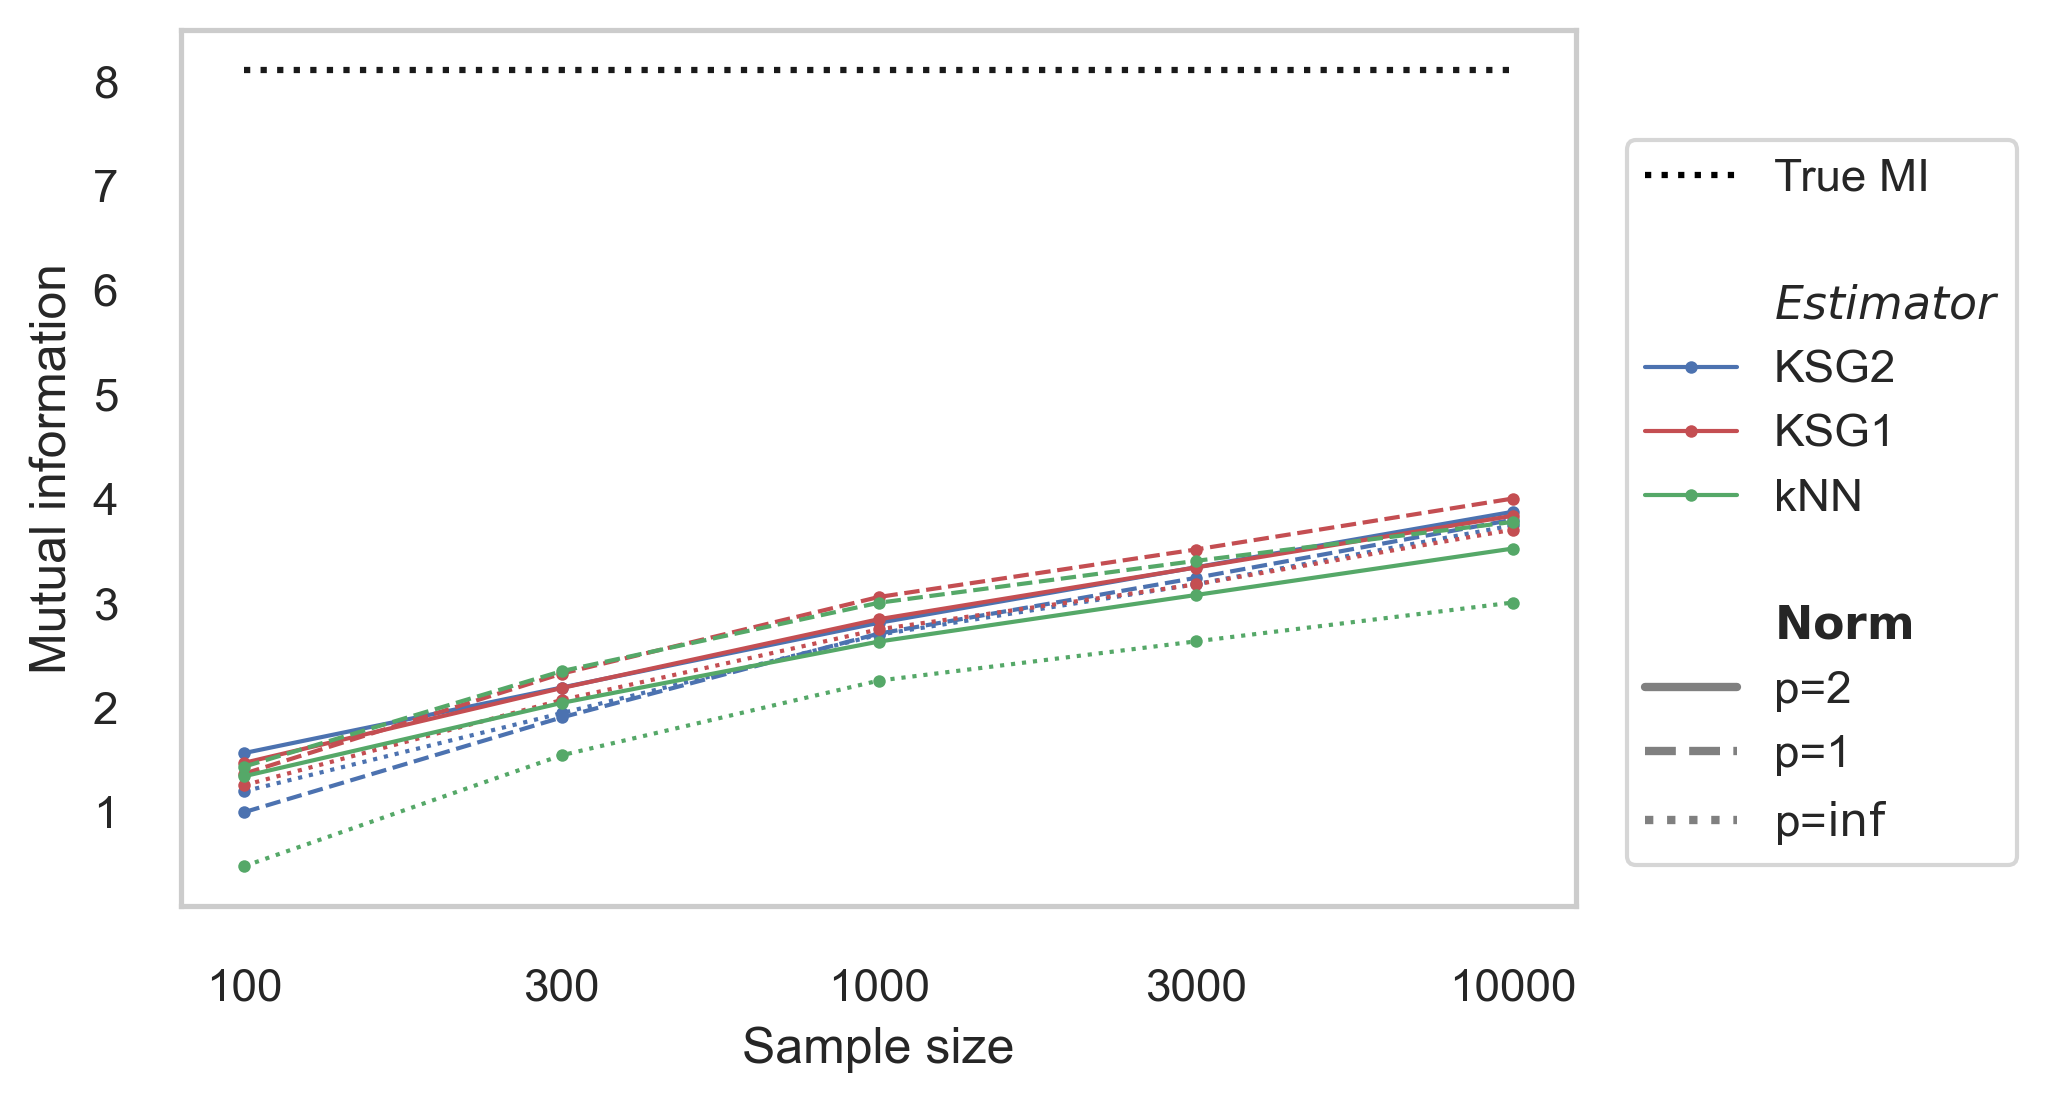

In [7]:
regexstr = runs_gauss_norm #runs_linear_norm
save = True
figname = 'gauss_10dim_pnorms' #'linear_10dim_pnorms'

run_dict = extract_run_history(regexstr)
run_dict = correct_faulty_implementation_bias(run_dict, correct_more=True)
True_MI = MIdict[regexstr]
name2clr = {'kNN': 'g', 'KSG1': 'r', 'KSG2': 'b', 'MINE': 'y', 'InfoNCE': 'm'}
norm2line = {1: '', 2: '--', 'inf': ':'}
labeldict = {'g': 'kNN', 'r': 'KSG1', 'b': 'KSG2',
             'g--': '', 'r--': '', 'b--': '',
             'g:': '', 'r:': '', 'b:': ''}
x_axis = ['100', '300', '1000', '3000', '10000']

plt.figure(figsize=(6,4))
for key, run in run_dict.items():
    str1 = name2clr[run[1]['Method.method_name']]
    str2 = norm2line[run_dict[key][1]['Method.p_norm']]
    plt.plot(x_axis, run[0], str1+str2, label=labeldict[str1+str2],
             linewidth=1, marker=".")
    
plt.grid(None)
plt.xlabel('Sample size')
plt.ylabel('Mutual information')
plt.gcf().subplots_adjust(bottom=0.15)

linestyles = ['-', '--', ':']
style_labels = ['p=2', 'p=1', 'p=$\inf$']

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()  # Get existing handles and labels

linestyle_handles = [plt.Line2D([0], [0], color='gray', linestyle=linestyle, lw=2) for linestyle in linestyles]
linestyle_labels = style_labels

handles = [plt.Line2D([0], [0], color='black', ls=':', label='True MI')] + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Estimator')] +  \
          handles + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Norm')] + linestyle_handles

labels = ['True MI', '', '$\mathit{Estimator}$'] + labels + ['', '$\mathbf{Norm}$'] + style_labels

# Create the combined legend
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 0.9),)
plt.plot(x_axis, [True_MI]*5, 'k:', label="True MI")

if save: plt.savefig(figname, bbox_inches = "tight")
plt.show()

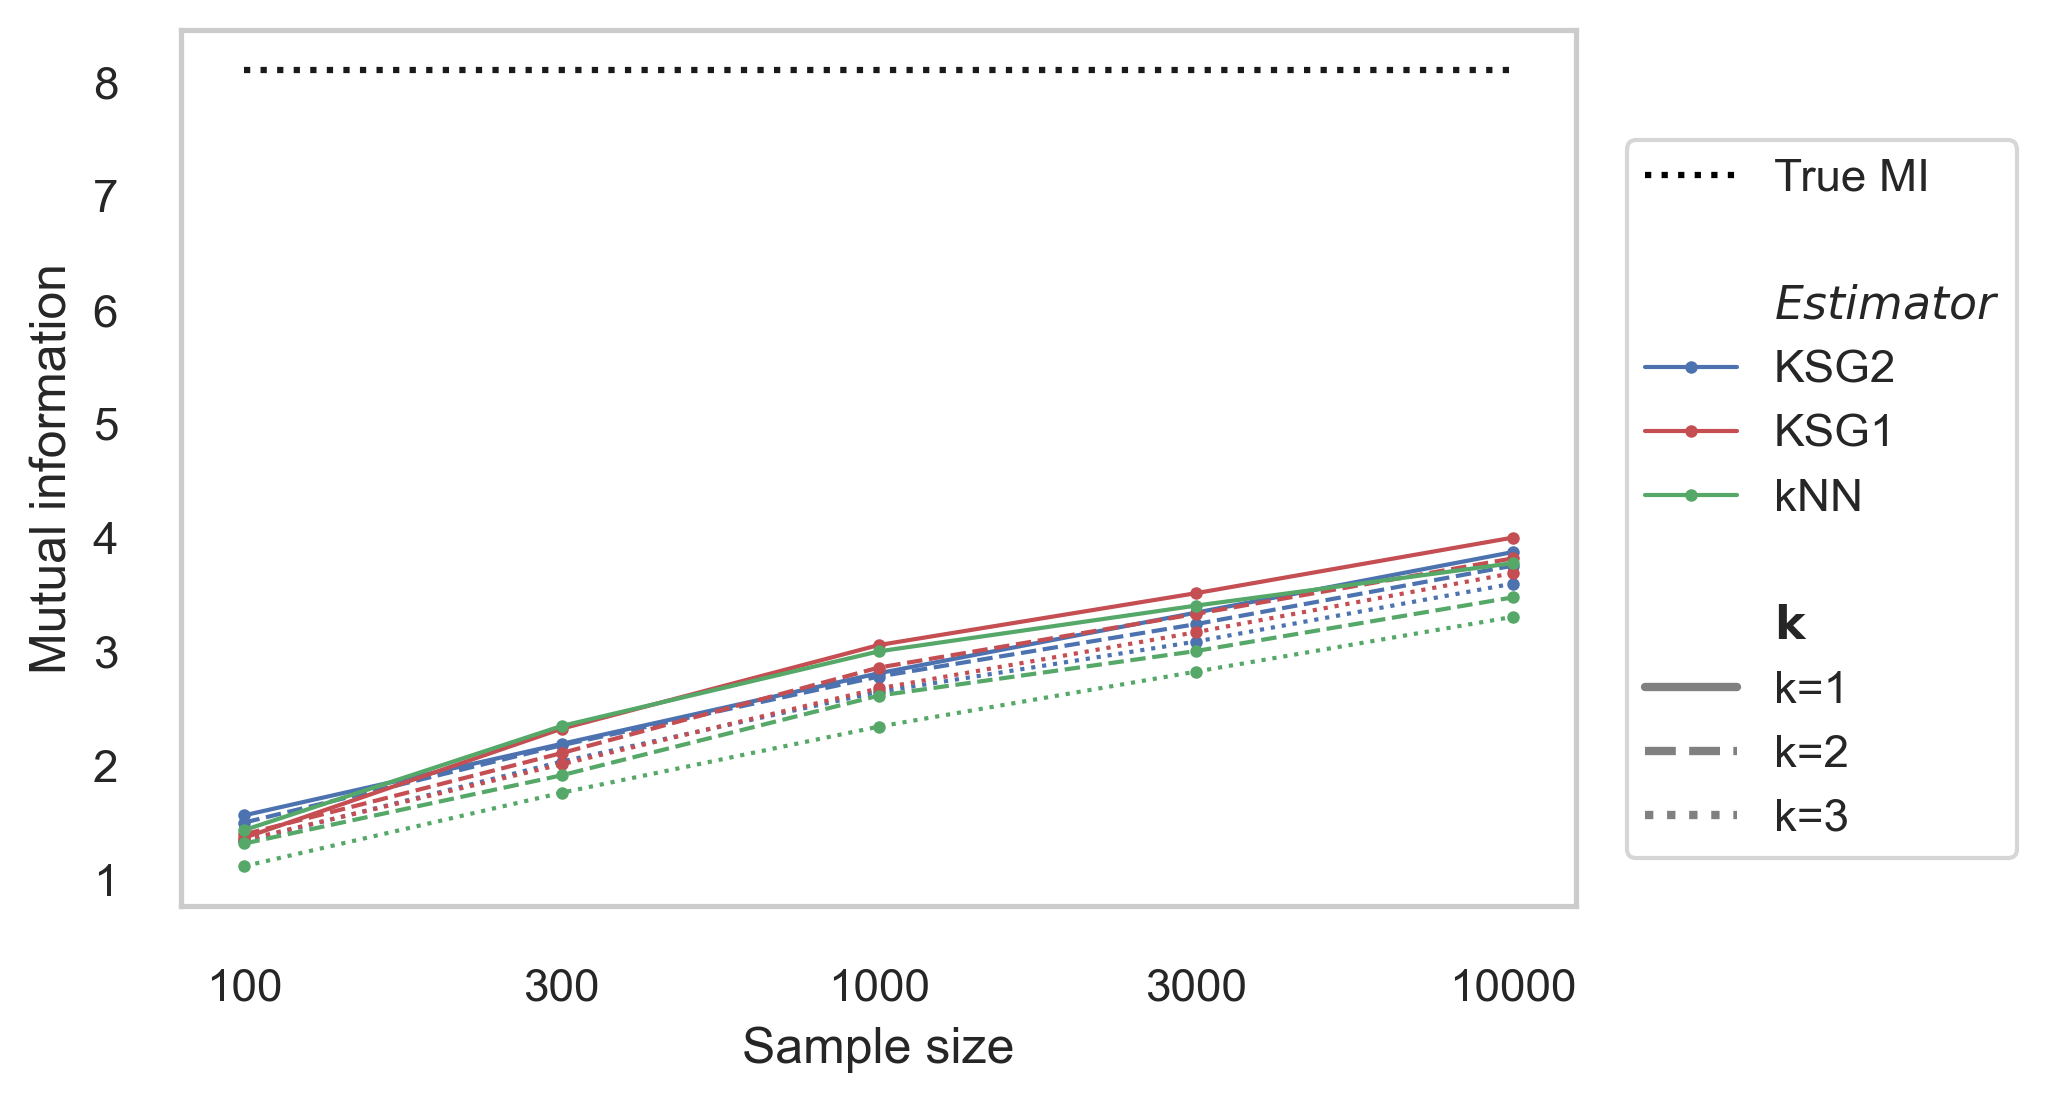

In [9]:
regexstr = runs_gauss_k #runs_linear_k 
save = True
figname = 'gauss_10dim_k' #'linear_10dim_k'

run_dict = extract_run_history(regexstr)
run_dict = correct_faulty_implementation_bias(run_dict, correct_more=True)
True_MI = MIdict[regexstr]
name2clr = {'kNN': 'g', 'KSG1': 'r', 'KSG2': 'b'}
k2line = {1: "", 2: "--", 3: ":", 4: ":", 5: ":"}
labeldict = {'g': 'kNN', 'r': 'KSG1', 'b': 'KSG2',
             'g--': '', 'r--': '', 'b--': '',
             'g:': '', 'r:': '', 'b:': ''}
x_axis = ['100', '300', '1000', '3000', '10000']

plt.figure(figsize=(6,4))
for key, run in run_dict.items():
    str1 = name2clr[run[1]['Method.method_name']]
    str2 = k2line[run[1]['Method.k']]
    plt.plot(x_axis, run[0], str1+str2, label=labeldict[str1+str2],
             linewidth=1, marker=".")
    
plt.grid(None)
plt.xlabel('Sample size')
plt.ylabel('Mutual information')
plt.gcf().subplots_adjust(bottom=0.15)

linestyles = ['-', '--', ':']
style_labels = ['k=1', 'k=2', 'k=3']

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()  # Get existing handles and labels

linestyle_handles = [plt.Line2D([0], [0], color='gray', linestyle=linestyle, lw=2) for linestyle in linestyles]
linestyle_labels = style_labels

handles = [plt.Line2D([0], [0], color='black', ls=':', label='True MI')] + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Estimator')] +  \
          handles + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Norm')] + linestyle_handles

labels = ['True MI', '', '$\mathit{Estimator}$'] + labels + ['', '$\mathbf{k}$'] + style_labels

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 0.9),)
plt.plot(x_axis, [True_MI]*5, 'k:', label="True MI")
    
if save: plt.savefig(figname, bbox_inches = "tight")
plt.show()

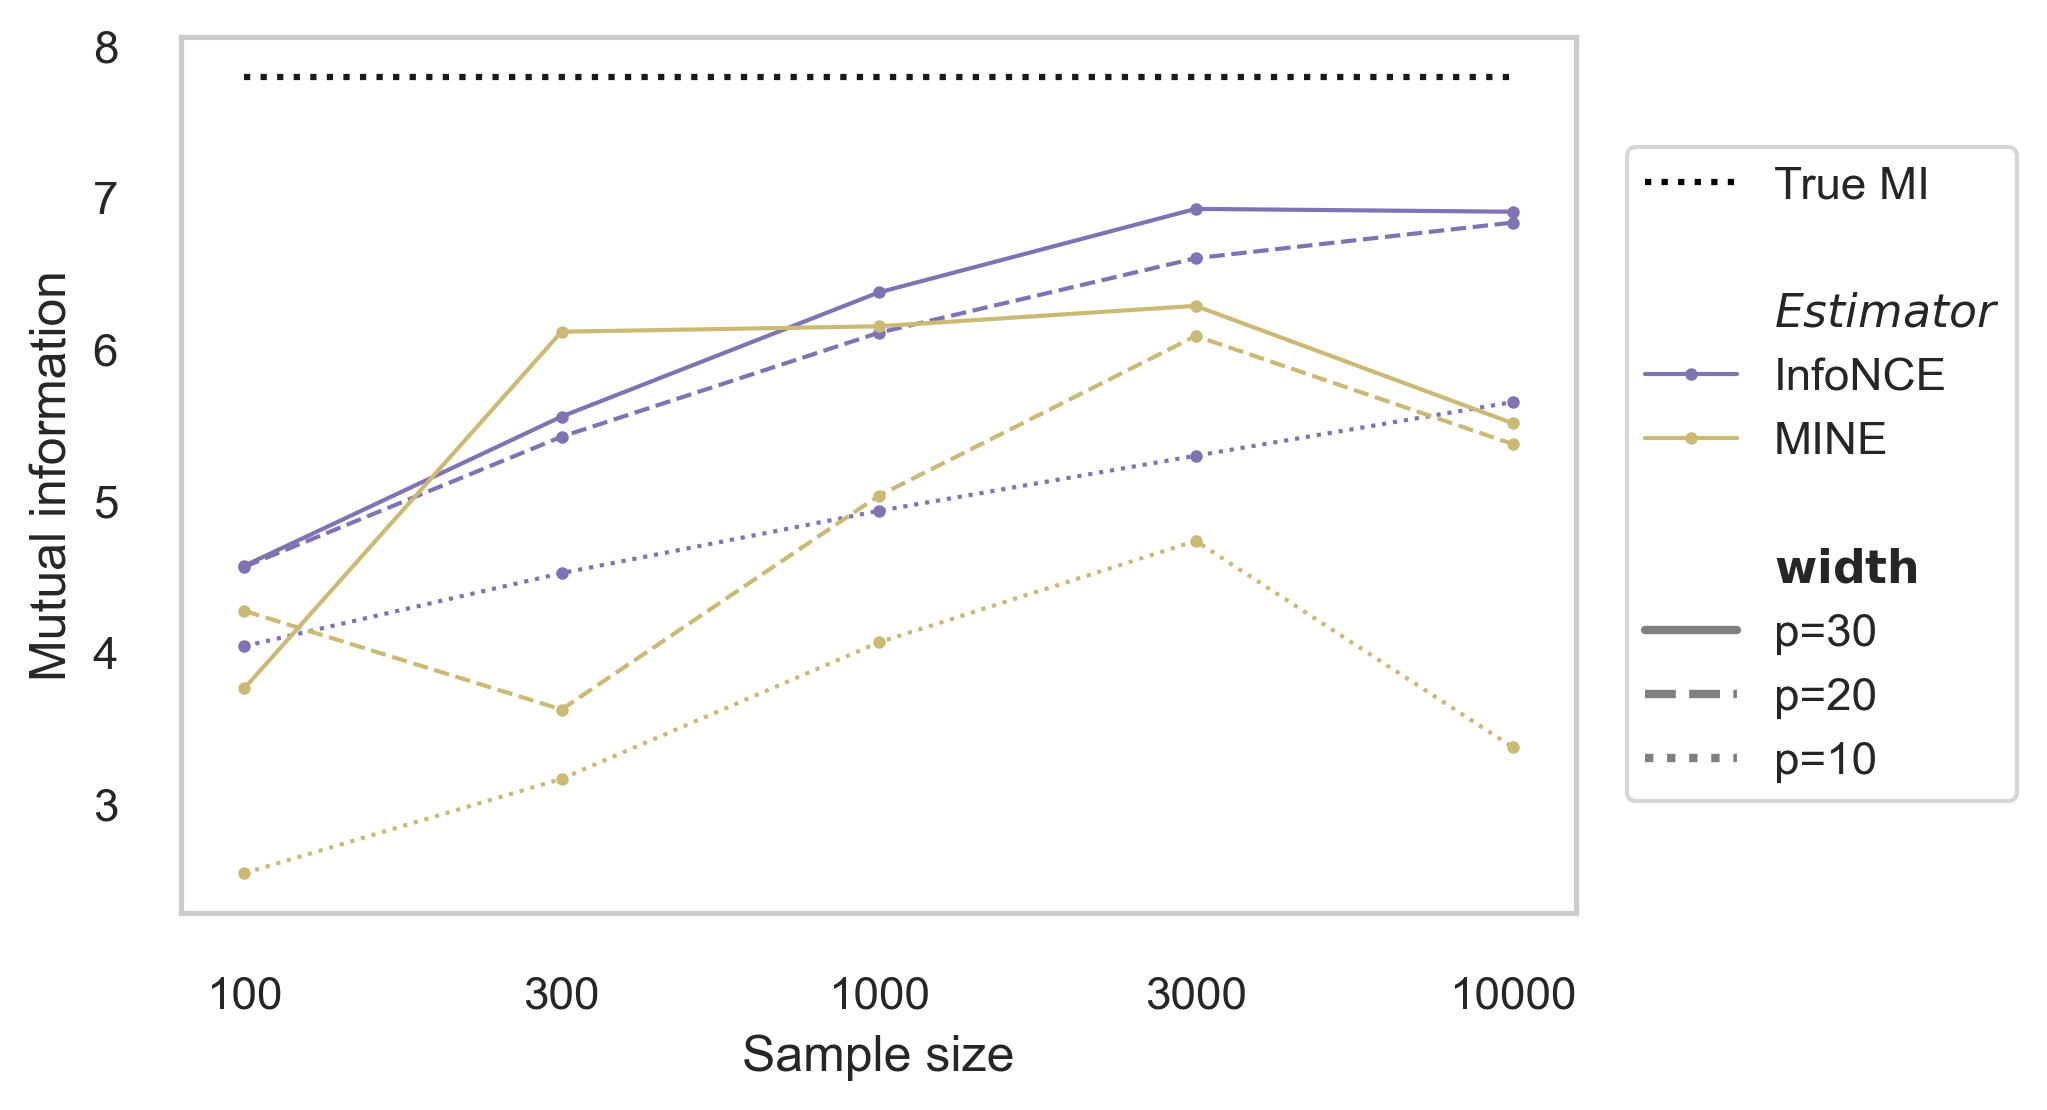

In [11]:
regexstr = runs_gauss_width #runs_linear_width
save = True
figname = 'gauss_10dim_width' #'linear_10dim_width'

run_dict = extract_run_history(regexstr)
True_MI = MIdict[regexstr]
name2clr = {'kNN': 'g', 'KSG1': 'r', 'KSG2': 'b', 'MINE': 'y', 'InfoNCE': 'm'}
width2line = {10: ':', 20: '--', 30: ''}
labeldict = {'g': 'kNN', 'r': 'KSG1', 'b': 'KSG2', 'y': 'MINE', 'm': 'InfoNCE',
             'g--': '', 'r--': '', 'b--': '', 'y--': '', 'm--': '',
             'g:': '', 'r:': '', 'b:': '', 'y:': '', 'm:': ''}
x_axis = ['100', '300', '1000', '3000', '10000']

plt.figure(figsize=(6,4))
for key, run in run_dict.items():
    str1 = name2clr[run[1]['Method.method_name']]
    str2 = width2line[run_dict[key][1]['Method.hidden_size']]
    #except KeyError: pass
    plt.plot(x_axis, run[0], str1+str2, label=labeldict[str1+str2],
             linewidth=1, marker=".")
    
plt.grid(None)
plt.xlabel('Sample size')
plt.ylabel('Mutual information')
plt.gcf().subplots_adjust(bottom=0.15)

linestyles = ['-', '--', ':']
style_labels = ['p=30', 'p=20', 'p=10']

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()  # Get existing handles and labels

linestyle_handles = [plt.Line2D([0], [0], color='gray', linestyle=linestyle, lw=2) for linestyle in linestyles]
linestyle_labels = style_labels

handles = [plt.Line2D([0], [0], color='black', ls=':', label='True MI')] + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Estimator')] +  \
          handles + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Norm')] + linestyle_handles

labels = ['True MI', '', '$\mathit{Estimator}$'] + labels + ['', '$\mathbf{width}$'] + style_labels

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 0.9),)
plt.plot(x_axis, [True_MI]*5, 'k:', label="True MI")
    
if save: plt.savefig(figname, bbox_inches = "tight")
plt.show()

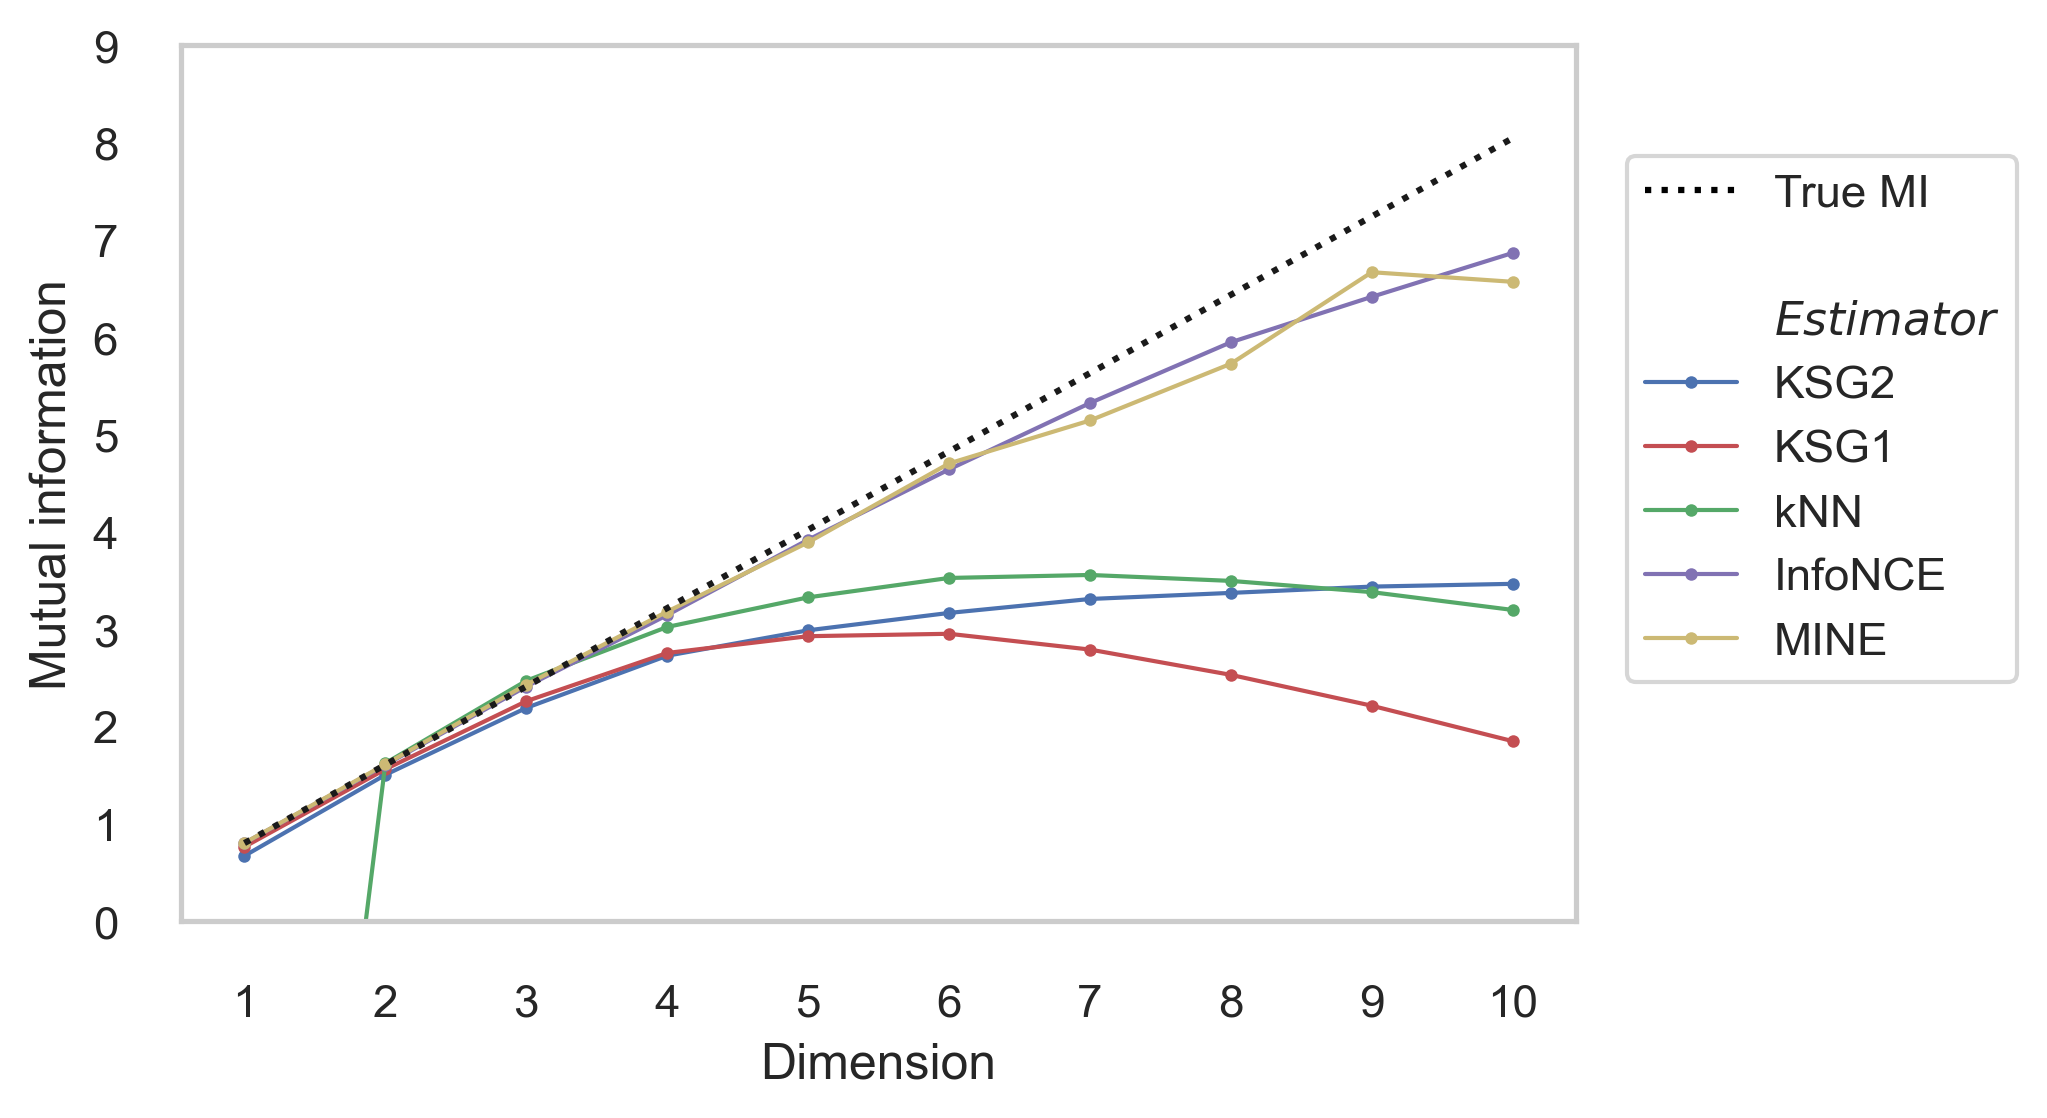

In [13]:
regexstr =  runs_gauss_dim #runs_linear_dim
save = True
figname = 'gauss_dim' #'linear_dim'

run_dict = extract_run_history(regexstr)
run_dict = correct_faulty_implementation_bias(run_dict)
True_MI = MIdict[regexstr]
name2clr = {'kNN': 'g', 'KSG1': 'r', 'KSG2': 'b', 'MINE': 'y', 'InfoNCE': 'm'}
x_axis = [str(i) for i in range(1,11)]

fig = plt.figure(figsize=(6,4))
for key, run in run_dict.items():
    #str1 = 
    #str2 = norm2line[run_dict[key][1]['Method.p_norm']]
    plt.plot(x_axis, run[0], name2clr[run[1]['Method.method_name']], label=run[1]['Method.method_name'], 
             linewidth=1, marker=".")

plt.grid(None)
plt.xlabel('Dimension')
plt.ylabel('Mutual information')
plt.gcf().subplots_adjust(bottom=0.15)
plt.ylim([0,9])

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()  # Get existing handles and labels

linestyle_handles = [plt.Line2D([0], [0], color='gray', linestyle=linestyle, lw=2) for linestyle in linestyles]
linestyle_labels = style_labels

handles = [plt.Line2D([0], [0], color='black', ls=':', label='True MI')] + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Estimator')] +  \
          handles + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Norm')] #+ linestyle_handles

labels = ['True MI', '', '$\mathit{Estimator}$'] + labels #+ ['', '$\mathbf{width}$'] + style_labels

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 0.9),)
plt.plot(x_axis, [(i/10) * True_MI for i in range(1,11)], 'k:', label="True MI")
    
if save: plt.savefig(figname, bbox_inches = "tight")
plt.show()

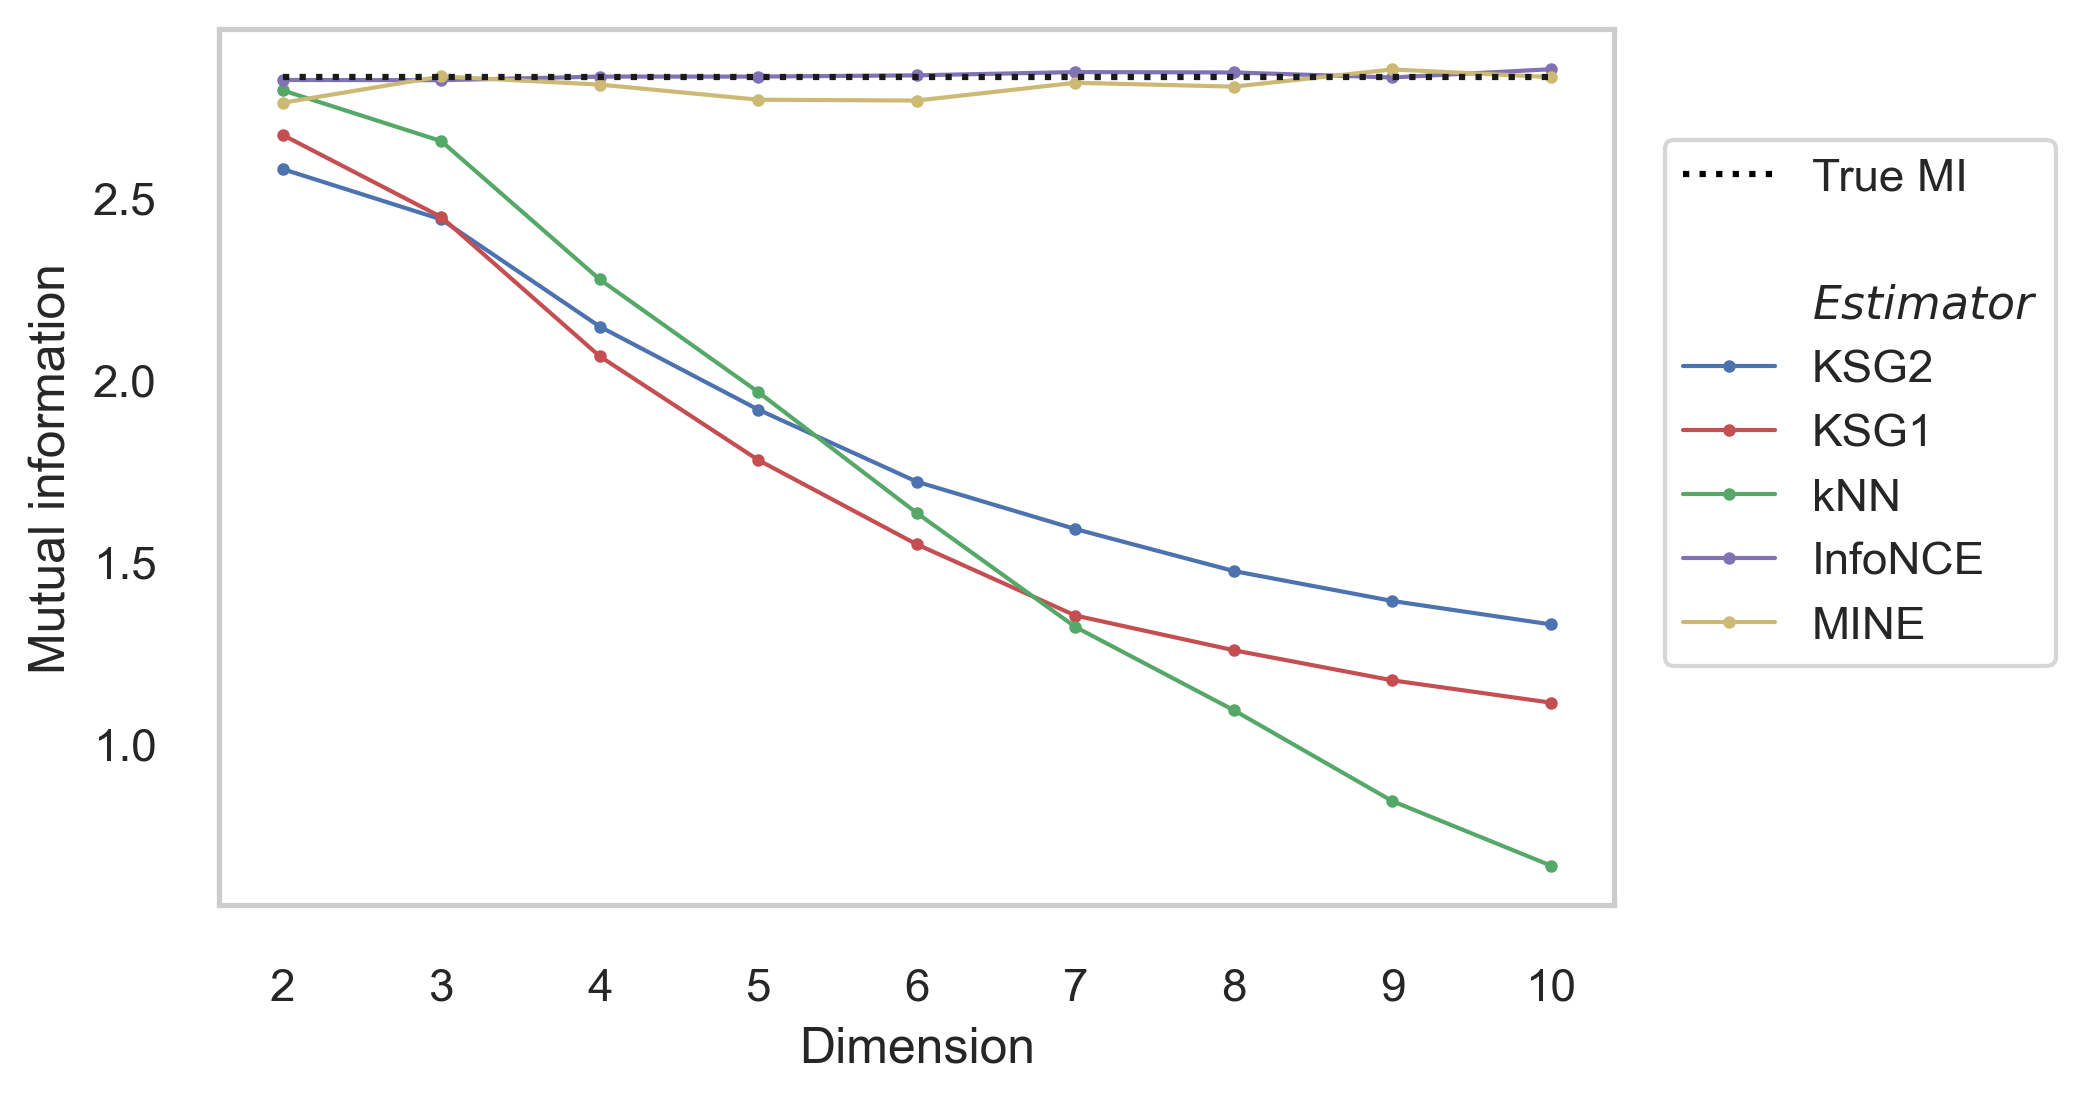

In [15]:
regexstr = runs_gauss_noise #runs_linear_noise
save = True
figname = 'gauss_noise' #'linear_noise'

run_dict = extract_run_history(regexstr)
run_dict = correct_faulty_implementation_bias(run_dict)
True_MI = MIdict[regexstr]
name2clr = {'kNN': 'g', 'KSG1': 'r', 'KSG2': 'b', 'MINE': 'y', 'InfoNCE': 'm'}
x_axis = [str(i) for i in range(2,11)]

plt.figure(figsize=(6,4))
for key, run in run_dict.items():
    #str1 = 
    #str2 = norm2line[run_dict[key][1]['Method.p_norm']]
    plt.plot(x_axis, run[0], name2clr[run[1]['Method.method_name']], label=run[1]['Method.method_name'],
             linewidth=1, marker=".")
    
plt.grid(None)
plt.xlabel('Dimension')
plt.ylabel('Mutual information')
plt.gcf().subplots_adjust(bottom=0.15)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()  # Get existing handles and labels

linestyle_handles = [plt.Line2D([0], [0], color='gray', linestyle=linestyle, lw=2) for linestyle in linestyles]
linestyle_labels = style_labels

handles = [plt.Line2D([0], [0], color='black', ls=':', label='True MI')] + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Estimator')] +  \
          handles + [plt.Line2D([0], [0], color='none', label='')] + \
          [plt.Line2D([0], [0], color='none', label='Norm')] #+ linestyle_handles

labels = ['True MI', '', '$\mathit{Estimator}$'] + labels #+ ['', '$\mathbf{width}$'] + style_labels

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 0.9),)
plt.plot(x_axis, [True_MI]*9, 'k:', label="True MI")
    
if save: plt.savefig(figname, bbox_inches = "tight")
plt.show()

**Ez csak szemét innenstől:**

In [ ]:
from torch import distributions

def correlated_linear(alpha=0.01, dim=3, batch_size=64):
    XX = distributions.uniform.Uniform(0.,1.)
    Alpha = distributions.uniform.Uniform(-alpha/2,alpha/2)

    var_x = XX.sample([dim,batch_size])
    var_y = var_x + Alpha.sample([dim,batch_size])
    
    return var_x, var_y

x, y = correlated_linear(alpha=alpha, dim=3, batch_size=5)
#print(x, y, x.shape, y.shape, type(x))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#testset = datasets.CIFAR10(root='./data', train=False,
#                           download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
lll = ['a', 'b', 'c']
for char in lll:
    if char == 'a' or char == 'b': print('jej')

jej
jej
